## Data Mining Term Project
## Haibo Wang
## 1001778514

## Data:https://www.kaggle.com/jvanelteren/boardgamegeek-reviews

In [3]:
import pandas as pd 
#from pandas import Series, DataFrame 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import sklearn
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso 
from sklearn.linear_model import ElasticNetCV 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
#from keras.preprocessing.sequence import pad_sequences

In [43]:
# load data
def read_data(file_path = 'bgg-13m-reviews.csv'):
    
    df = pd.read_csv(file_path,  names=['index', 'user', 'rating', 'comment', 'id', 'name'])
    df = df.dropna(axis=0, how='any')
    df = df[0:400000]
    print(df.shape)
    return df

# data preprocessing and tokenize
def sentence2tokens(sentence):
    stoplist = set('for a of the and to in ! “ ‘ # $ % & ( )'.split())
    tokens = [word for word in sentence.split(" ") if (word not in stoplist)]
    return tokens

# generate the vector of a sentence
def sentence2vector(sentence, model):
    tokens = sentence2tokens(sentence)
    try:
        vectors = model[tokens]
        return np.mean(vectors, axis=0)
    except:
        return np.zeros(300)
    
# generate the vector of a corpus
def corpus2vector(corpus, model):
    MAX_NB_WORDS = 10000
    MAX_SEQUENCE_LENGTH = 300

    corpus_vectors = np.array([sentence2vector(comment, model) for comment in corpus])
    corpus_vectors = np.array([v for v in corpus_vectors if np.sum(v != None)])          
    return corpus_vectors

# Standardization
def uniform_norm(X):
    X_max = X.max(axis=0)
    X_min = X.min(axis=0)
    return (X - X_min) / (X_max - X_min), X_max, X_min

# Visualization
def draw(pred,test_Y):
    t = np.arange(0, len(pred),1000) 
    plt.figure() 

    plt.plot(t, test_Y[::1000], 'red', label='true value') 
    plt.plot(t, pred[::1000], 'blue', label='estimated') 

    plt.legend(loc='best') 
    plt.title('game') 
    plt.xlabel('comment') 
    plt.ylabel('rating')  
    plt.show()



## Word2vec -- GoogleNews-vectors-negative300.bin

In [44]:
# import word2vec to use word embedding    
import gensim
word_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 


## convert the csv to dataframe

In [6]:
data = read_data()


X = data['comment']
Y = data['rating']

/Users/faith/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (2,4) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(400000, 6)


In [7]:
data.head()

,index,user,rating,comment,id,name
3,2.0,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,Catan
4,3.0,cypar7,10.0,"I know it says how many plays, but many, many ...",13,Catan
8,7.0,hreimer,10.0,i will never tire of this game.. Awesome,13,Catan
12,11.0,daredevil,10.0,This is probably the best game I ever played. ...,13,Catan
17,16.0,hurkle,10.0,Fantastic game. Got me hooked on games all ove...,13,Catan


In [8]:
X[0:10]

3     Currently, this sits on my list as my favorite...
4     I know it says how many plays, but many, many ...
8              i will never tire of this game.. Awesome
12    This is probably the best game I ever played. ...
17    Fantastic game. Got me hooked on games all ove...
18    One of the best games ever created. Period. Ne...
20    Game itself is 9. Only strategy game my family...
21    This is a great game.  I've even got a number ...
22    One of my all time favorite games. I usually o...
26    Settlers is a gem. If you havn't played it I s...
Name: comment, dtype: object

In [9]:
Y[0:10]

3     10.0
4     10.0
8     10.0
12    10.0
17    10.0
18    10.0
20    10.0
21    10.0
22    10.0
26    10.0
Name: rating, dtype: object

## Divided into training set and test set
## Standardization

In [10]:
# Divided into training set and test set
train_X, test_X, train_Y, test_Y = train_test_split(X,Y, test_size = 0.1, random_state = 42)

train_X = corpus2vector(train_X, word_model)
test_X = corpus2vector(test_X, word_model)

unif_train_X, max_X, min_X = uniform_norm(train_X)
unif_test_X = (test_X - min_X) / (max_X - min_X)

In [11]:
train_X

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01431885,  0.12670898, -0.07094727, ..., -0.04813232,
         0.01752624,  0.01533203],
       ...,
       [-0.06306966, -0.00065104,  0.04785156, ..., -0.07063802,
         0.08671061, -0.03645833],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [12]:
unif_train_X

array([[0.50146628, 0.54035088, 0.5497076 , ..., 0.53454545, 0.42857143,
        0.52892562],
       [0.50146628, 0.54035088, 0.5497076 , ..., 0.53454545, 0.42857143,
        0.52892562],
       [0.51221591, 0.65416667, 0.47889863, ..., 0.48973864, 0.44347747,
        0.53973829],
       ...,
       [0.45411779, 0.53976608, 0.59746589, ..., 0.46878788, 0.50231866,
        0.50321396],
       [0.50146628, 0.54035088, 0.5497076 , ..., 0.53454545, 0.42857143,
        0.52892562],
       [0.50146628, 0.54035088, 0.5497076 , ..., 0.53454545, 0.42857143,
        0.52892562]])

## Training different regression models

In [13]:
# Linear regression model
model1 = LinearRegression()
# Ridge regression model
model2 = Ridge()
# Lasso regression model
model3 = Lasso()
# ElasticNetCV model
model4 = ElasticNetCV()

# different depth of decision tree regressor
model5 = DecisionTreeRegressor(max_depth = 1)
model6 = DecisionTreeRegressor(max_depth = 3)
model7 = DecisionTreeRegressor(max_depth = 6)

In [14]:
model1.fit(unif_train_X, train_Y)
model2.fit(unif_train_X, train_Y)
model3.fit(unif_train_X, train_Y)
model4.fit(unif_train_X, train_Y)
model5.fit(unif_train_X, train_Y)
model6.fit(unif_train_X, train_Y)
model7.fit(unif_train_X, train_Y)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

## Test models

In [15]:
#pred_train = model.predict(unif_train_X)
pred1 = model1.predict(unif_test_X)
pred2 = model2.predict(unif_test_X)
pred3 = model3.predict(unif_test_X)
pred4 = model4.predict(unif_test_X)
pred5 = model5.predict(unif_test_X)
pred6 = model6.predict(unif_test_X)
pred7 = model7.predict(unif_test_X)

print("LinearRegression------")
print("MSE1", mean_squared_error(test_Y, pred1))
print("RMSE1",np.sqrt(mean_squared_error(test_Y,pred1)))
print("MAE1", metrics.mean_absolute_error(test_Y, pred1))

print("***********************")
print("Ridge------")
print("MSE2 ", mean_squared_error(test_Y, pred2))
print("RMSE2",np.sqrt(mean_squared_error(test_Y,pred2)))
print("MAE2", metrics.mean_absolute_error(test_Y, pred2))

print("***********************")
print("Lasso------")
print("MSE3", mean_squared_error(test_Y, pred3))
print("RMSE3",np.sqrt(mean_squared_error(test_Y,pred3)))
print("MAE3", metrics.mean_absolute_error(test_Y, pred3))

print("***********************")
print("ElasticNetCV------")
print("MSE4", mean_squared_error(test_Y, pred4))
print("RMSE4",np.sqrt(mean_squared_error(test_Y,pred4)))
print("MAE4", metrics.mean_absolute_error(test_Y, pred4))

print("***********************")
print("DecisionTreeRegressor(max_depth = 1)------")
print("MSE5", mean_squared_error(test_Y, pred5))
print("RMSE5",np.sqrt(mean_squared_error(test_Y,pred5)))
print("MAE5", metrics.mean_absolute_error(test_Y, pred5))

print("***********************")
print("DecisionTreeRegressor(max_depth = 3)------")
print("MSE6 ", mean_squared_error(test_Y, pred6))
print("RMSE6",np.sqrt(mean_squared_error(test_Y,pred6)))
print("MAE6", metrics.mean_absolute_error(test_Y, pred6))

print("***********************")
print("DecisionTreeRegressor(max_depth = 6)------")
print("MSE7 ", mean_squared_error(test_Y, pred7))
print("RMSE7",np.sqrt(mean_squared_error(test_Y,pred7)))
print("MAE7", metrics.mean_absolute_error(test_Y, pred7))

LinearRegression------
MSE1 2.885424347103564
RMSE1 1.6986536866305515
MAE1 1.3083312347715774
***********************
Ridge------
MSE2  2.8854158441665443
RMSE2 1.6986511837827518
MAE2 1.3083306964122337
***********************
Lasso------
MSE3 2.915484791934709
RMSE3 1.7074790751088895
MAE3 1.3161503162305628
***********************
ElasticNetCV------
MSE4 2.8857893026017605
RMSE4 1.6987611081614038
MAE4 1.3084938562501078
***********************
DecisionTreeRegressor(max_depth = 1)------
MSE5 2.912975735578299
RMSE5 1.706744191605262
MAE5 1.316152065996292
***********************
DecisionTreeRegressor(max_depth = 3)------
MSE6  2.907673685531794
RMSE6 1.7051902197502171
MAE6 1.3151368087476631
***********************
DecisionTreeRegressor(max_depth = 6)------
MSE7  2.9015798695125588
RMSE7 1.7034024390943436
MAE7 1.3126547281562675


## Visualization

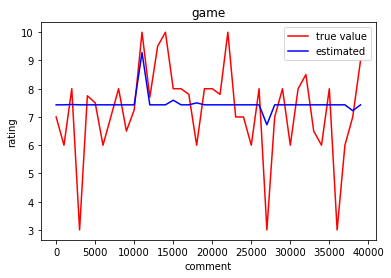

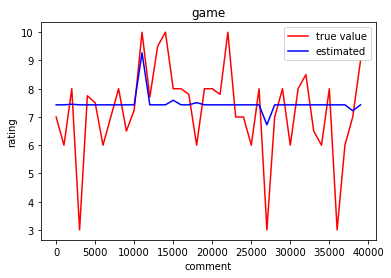

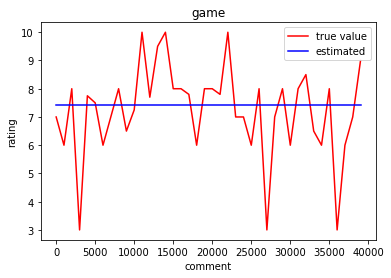

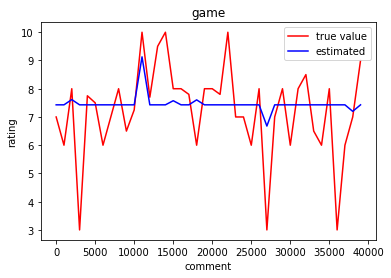

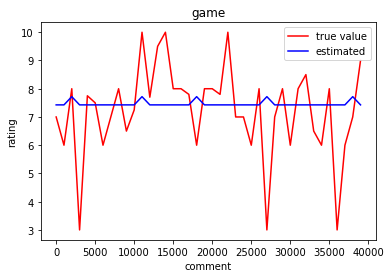

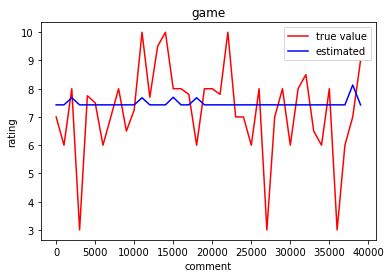

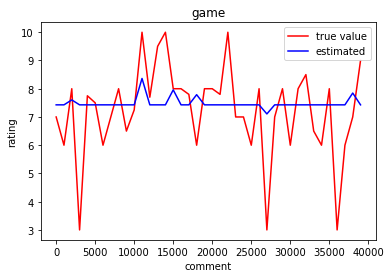

In [29]:
draw(pred1,test_Y)
draw(pred2,test_Y)
draw(pred3,test_Y)
draw(pred4,test_Y)
draw(pred5,test_Y)
draw(pred6,test_Y)
draw(pred7,test_Y)

In [51]:
text1 = "Fantastic game. Got me hooked on games all over again."

In [52]:
def rating(text):
    vec = corpus2vector(text, word_model)
    #s = pad_sequences(tokenized, maxlen=maxlen)
    pred = model2.predict(vec)
#     if pred > 10:
#         return 10
    return pred

In [61]:
rating([text1])

array([10.51221594])